# Georgia Coastal Ecosystems LTER (GCE)

In [1]:
watershed = 'GeorgiaCoastalEcosystems'

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

In [4]:
# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

In [5]:
# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed
                'Precipitation':(0,400), 
                'AirTemperature':(-20,50), 
                'SolarRadiation':(-50,200), # 1361), avoid unreasonable values
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999), 
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100), 
                'SoilTemperature': (-20,50), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]
    
    for i in range(len(prep.columns)):
        col = prep.columns[i]
      
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))
        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        

        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])        

        # plt.figure(i)
        # prep_new[prep_new.columns[i]].plot()
    
    return prep

In [6]:
# Data were accessed on 5/4/2020

### 1. Discharge

In [7]:
# Streamflow data from USGS
# USGS 02226000 ALTAMAHA RIVER AT DOCTORTOWN, GA
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=02226000&referred_module=sw&period=&begin_date=1957-05-01&end_date=2020-12-31',
                    header = 0,skiprows = 29 ,parse_dates = True,sep = '\t' ,infer_datetime_format = True)
data.head(3)

agency_cd   site_no    datetime 35988_00060_00003 35988_00060_00003_cd
0        5s       15s         20d               14n                  10s
1      USGS  02226000  1957-05-01             10000                    A
2      USGS  02226000  1957-05-02              9620                    A

In [8]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['35988_00060_00003']))
prep.columns = ['Altamaha_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)

Altamaha_Discharge
datetime                      
1957-05-01             10000.0
1957-05-02              9620.0
1957-05-03              9620.0

Altamaha_Discharge
datetime                      
2020-12-29              8960.0
2020-12-30              9810.0
2020-12-31             10700.0

Altamaha_Discharge


Altamaha_Discharge
1957-05-01            283000.0
1957-05-02            272246.0
1957-05-03            272246.0
1957-05-04            288660.0
1957-05-05            288660.0

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

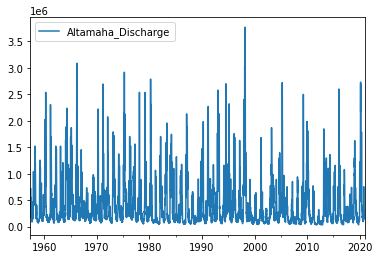

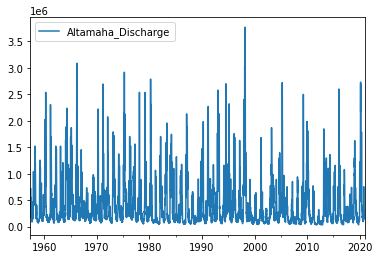

In [9]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]* 28.3 #( to L/s)
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge')            
Discharge = copy.deepcopy(df)
Discharge.plot()
Discharge.head()

## Hydrometeorology Variables

### Read Data

#### Sapelo met station

In [12]:
# Read meteorology data
sapelo = pd.read_csv("https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-gce.7.20&entityid=63113653acaa88833a773cfd54b79335",
                    header=0,skiprows=4,parse_dates=True,sep=',',infer_datetime_format=True)
sapelo.head(3)

datetime  datetime.1  datetime.2  data  data.1  data.2  calculation  \
0      1957           5           1  24.4    20.6    21.1         22.8   
1      1957           5           2  28.3    18.9    21.7         23.9   
2      1957           5           3  26.1    16.7    22.8         21.7   

   data.3  logical  
0    7.37        0  
1    2.29        0  
2   37.59        0

In [13]:
# rename the data columns according to the metadata file
sapelo.columns = ['year','month','date','Daily_AirTemp_Max', 'Daily_AirTemp_Min', 'Daily_AirTemp_Obs',
                  'Sapelo_AirTemperature','Sapelo_Precipitation','Provisional']
sapelo.head(3)

year  month  date  Daily_AirTemp_Max  Daily_AirTemp_Min  Daily_AirTemp_Obs  \
0  1957      5     1               24.4               20.6               21.1   
1  1957      5     2               28.3               18.9               21.7   
2  1957      5     3               26.1               16.7               22.8   

   Sapelo_AirTemperature  Sapelo_Precipitation  Provisional  
0                   22.8                  7.37            0  
1                   23.9                  2.29            0  
2                   21.7                 37.59            0

In [14]:
dt = [str(a)+'-'+str(b)+'-'+str(c) for a,b,c in zip(sapelo['year'], sapelo['month'], sapelo['date'])]
sapelo['DateTime'] = pd.to_datetime(dt)
sapelo.set_index('DateTime', inplace = True)
sapelo.head()

year  month  date  Daily_AirTemp_Max  Daily_AirTemp_Min  \
DateTime                                                              
1957-05-01  1957      5     1               24.4               20.6   
1957-05-02  1957      5     2               28.3               18.9   
1957-05-03  1957      5     3               26.1               16.7   
1957-05-04  1957      5     4               26.7               10.6   
1957-05-05  1957      5     5               19.4               10.6   

            Daily_AirTemp_Obs  Sapelo_AirTemperature  Sapelo_Precipitation  \
DateTime                                                                     
1957-05-01               21.1                   22.8                  7.37   
1957-05-02               21.7                   23.9                  2.29   
1957-05-03               22.8                   21.7                 37.59   
1957-05-04               10.6                   18.9                 33.78   
1957-05-05               17.2                   15.0                  0.51   

            Provisional  
DateTime                 
1957-05-01            0  
1957-05-02            0  
1957-05-03            0  
1957-05-04            0  
1957-05-05            0

In [22]:
sapelo.tail()

year  month  date  Daily_AirTemp_Max  Daily_AirTemp_Min  \
DateTime                                                              
2001-07-27  2001      7    27               31.7               23.9   
2001-07-28  2001      7    28               32.2               23.9   
2001-07-29  2001      7    29               34.4               23.9   
2001-07-30  2001      7    30               34.4               25.0   
2001-07-31  2001      7    31               34.4               25.0   

            Daily_AirTemp_Obs  Sapelo_AirTemperature  Sapelo_Precipitation  \
DateTime                                                                     
2001-07-27               30.0                   27.8                  0.00   
2001-07-28               27.8                   28.3                  0.00   
2001-07-29               33.3                   29.4                  0.00   
2001-07-30               28.9                   30.0                  0.00   
2001-07-31               28.9                   30.0                  3.81   

            Provisional  
DateTime                 
2001-07-27            1  
2001-07-28            1  
2001-07-29            1  
2001-07-30            1  
2001-07-31            1

#### MarshLanding

In [20]:
# Read meteorology data
marshlanding = pd.read_csv('https://portal.edirepository.org/nis/dataviewer?packageid=knb-lter-gce.421.5&entityid=9fdfd2b47004f655f98152e9a1ae1e63',
                    header = 0,skiprows = 4 ,parse_dates = True,sep = ',',infer_datetime_format = True)
marshlanding.head()

nominal nominal.1             datetime  datetime.1  datetime.2  \
0  3B036592     SAXG1  2009-01-01 00:00:00        2009           1   
1  3B036592     SAXG1  2009-01-01 00:15:00        2009           1   
2  3B036592     SAXG1  2009-01-01 00:30:00        2009           1   
3  3B036592     SAXG1  2009-01-01 00:45:00        2009           1   
4  3B036592     SAXG1  2009-01-01 01:00:00        2009           1   

   datetime.3  datetime.4  datetime.5    data  code  ...  data.5 code.9  \
0           1           0           0  11.861   NaN  ...     0.0    NaN   
1           1           0          15  10.211   NaN  ...     0.0    NaN   
2           1           0          30  10.761   NaN  ...     0.0    NaN   
3           1           0          45  10.550   NaN  ...     0.0    NaN   
4           1           1           0  10.611   NaN  ...     0.0    NaN   

   data.6 code.10  calculation.4 code.11  data.7  code.12  calculation.5  \
0     0.0     NaN            0.0     NaN     0.0      NaN            0.0   
1     0.0     NaN            0.0     NaN     0.0      NaN            0.0   
2     0.0     NaN            0.0     NaN     0.0      NaN            0.0   
3     0.0     NaN            0.0     NaN     0.0      NaN            0.0   
4     0.0     NaN            0.0     NaN     0.0      NaN            0.0   

  code.13  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  

[5 rows x 36 columns]

In [21]:
marshlanding.tail()

nominal nominal.1             datetime  datetime.1  datetime.2  \
35035  3B036592     SAXG1  2009-12-31 22:45:00        2009          12   
35036  3B036592     SAXG1  2009-12-31 23:00:00        2009          12   
35037  3B036592     SAXG1  2009-12-31 23:15:00        2009          12   
35038  3B036592     SAXG1  2009-12-31 23:30:00        2009          12   
35039  3B036592     SAXG1  2009-12-31 23:45:00        2009          12   

       datetime.3  datetime.4  datetime.5    data  code  ...  data.5 code.9  \
35035          31          22          45  15.139   NaN  ...     0.0    NaN   
35036          31          23           0  14.889   NaN  ...     0.0    NaN   
35037          31          23          15  14.700   NaN  ...     0.0    NaN   
35038          31          23          30  14.661   NaN  ...     0.0    NaN   
35039          31          23          45  14.711   NaN  ...     0.0    NaN   

       data.6 code.10  calculation.4 code.11  data.7  code.12  calculation.5  \
35035     5.0     NaN            5.6     NaN     0.0      NaN            0.0   
35036     0.0     NaN            0.0     NaN     0.0      NaN            0.0   
35037     0.0     NaN            0.0     NaN     0.0      NaN            0.0   
35038     0.0     NaN            0.0     NaN     0.0      NaN            0.0   
35039     0.0     NaN            0.0     NaN     0.0      NaN            0.0   

      code.13  
35035     NaN  
35036     NaN  
35037     NaN  
35038     NaN  
35039     NaN  

[5 rows x 36 columns]

In [ ]:
marshlanding = marshlanding.iloc[:,[2,20,80,120,160,176,254]]

In [ ]:
marshlanding.columns =['DateTime', 'MarshLanding_AirTemperature','MarshLanding_RelativeHumidity',
                      'MarshLanding_WindSpeed','MarshLanding_WindDirection',
                      'MarshLanding_Precipitation','MarshLanding_SolarRadiation']
marshlanding.set_index('DateTime',inplace = True)
marshlanding.head(2)

### 2. Precipitation

In [ ]:
sapelo_ppt = sapelo[['Sapelo_Precipitation']]
marshlanding_ppt = marshlanding[['MarshLanding_Precipitation']]
df_lst = [sapelo_ppt,marshlanding_ppt]
for df in df_lst:     
    threC(df,'Precipitation') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "sum")

Altamaha_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

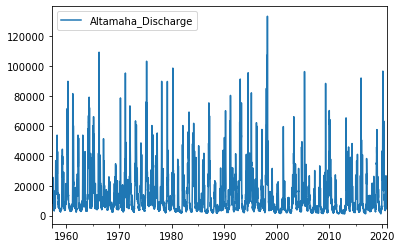

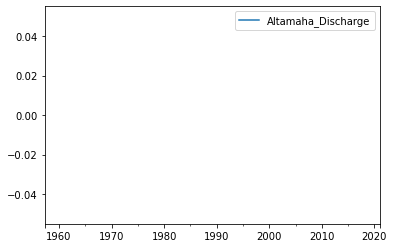

In [17]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'Precipitation')    
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. AirTemperature 

In [18]:
sapelo_AT = sapelo[['Sapelo_AirTemperature']]
marshlanding_AT = marshlanding[['MarshLanding_AirTemperature']]
df_lst = [sapelo_AT,marshlanding_AT]
for df in df_lst:     
    threC(df,'AirTemperature') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean")

KeyError: "None of [Index(['MarshLanding_AirTemperature'], dtype='object')] are in the [columns]"

In [ ]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! AirTemperature unit should be degree celsius
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'AirTemperature')    
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 4. SolarRadiation

In [ ]:
marshlanding_SR = marshlanding[['MarshLanding_SolarRadiation']]
df_lst = [marshlanding_SR]
for df in df_lst:     
    threC(df,'SolarRadiation') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean")

In [ ]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SolarRadiation unit should be W/m2
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*1000  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'SolarRadiation')    
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()

### 5. RelativeHumidity

In [ ]:
marshlanding_RH = marshlanding[['MarshLanding_RelativeHumidity']]
df_lst = [marshlanding_RH]
for df in df_lst:     
    threC(df,'RelativeHumidity') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean")

In [ ]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! RelativeHumidity unit should be %
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'RelativeHumidity')    
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()

### 6. WindDirection

In [19]:
marshlanding_WD = marshlanding[['MarshLanding_WindDirection']]
df_lst = [marshlanding_WD]
for df in df_lst:     
    threC(df,'WindDirection') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean")

KeyError: "None of [Index(['MarshLanding_WindDirection'], dtype='object')] are in the [columns]"

MarshLanding_WindDirection


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

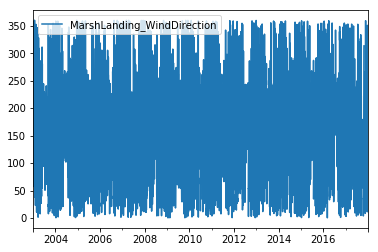

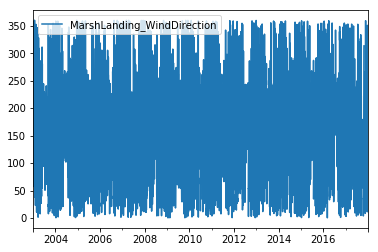

In [26]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindDirection unit should be degree
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'WindDirection')    
WindDirection = copy.deepcopy(df)
WindDirection.plot()

### 7. WindSpeed

In [27]:
marshlanding_WS = marshlanding[['MarshLanding_WindSpeed']]
df_lst = [marshlanding_WS]
for df in df_lst:     
    threC(df,'WindSpeed') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean")

MarshLanding_WindSpeed
DateTime                          
2003-01-03                   7.814
2003-01-04                   5.236

(5477, 1)
2003-01-03 00:00:00 2017-12-31 00:00:00
The final table is:


MarshLanding_WindSpeed
2003-01-03                  7.814
2003-01-04                  5.236

MarshLanding_WindSpeed
2017-12-30                  2.437
2017-12-31                  2.755

MarshLanding_WindSpeed


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

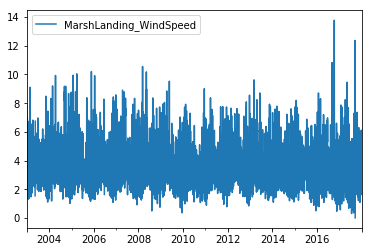

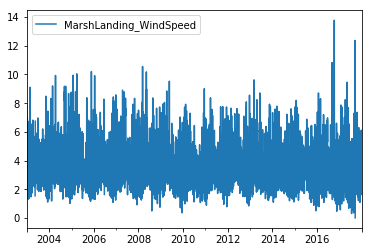

In [28]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindSpeed unit should be m/s
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
threC(df,'WindSpeed')    
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()

In [29]:
### 8. SWE

In [30]:
### 9. SnowDepth

In [31]:
### 10. VaporPressure 

In [32]:
### 11. SoilMoisture

In [33]:
### 12. SoilTemperature

In [34]:
### 13. Isotope

### Combine all data tables

In [39]:
result = pd.concat([Discharge,Precipitation,AirTemperature,
                    SolarRadiation,RelativeHumidity, 
                    WindDirection,WindSpeed],
                    axis=1,
                    join='outer')######
result.index.rename('DateTime',inplace = True)
display(result.head())
result.tail()

Altamaha_Discharge  Sapelo_Precipitation  \
DateTime                                               
1957-05-01            283000.0                  7.37   
1957-05-02            272246.0                  2.29   
1957-05-03            272246.0                 37.59   
1957-05-04            288660.0                 33.78   
1957-05-05            288660.0                  0.51   

            MarshLanding_Precipitation  Sapelo_AirTemperature  \
DateTime                                                        
1957-05-01                         NaN                   22.8   
1957-05-02                         NaN                   23.9   
1957-05-03                         NaN                   21.7   
1957-05-04                         NaN                   18.9   
1957-05-05                         NaN                   15.0   

            MarshLanding_AirTemperature  MarshLanding_SolarRadiation  \
DateTime                                                               
1957-05-01                          NaN                          NaN   
1957-05-02                          NaN                          NaN   
1957-05-03                          NaN                          NaN   
1957-05-04                          NaN                          NaN   
1957-05-05                          NaN                          NaN   

            MarshLanding_RelativeHumidity  MarshLanding_WindDirection  \
DateTime                                                                
1957-05-01                            NaN                         NaN   
1957-05-02                            NaN                         NaN   
1957-05-03                            NaN                         NaN   
1957-05-04                            NaN                         NaN   
1957-05-05                            NaN                         NaN   

            MarshLanding_WindSpeed  
DateTime                            
1957-05-01                     NaN  
1957-05-02                     NaN  
1957-05-03                     NaN  
1957-05-04                     NaN  
1957-05-05                     NaN

Altamaha_Discharge  Sapelo_Precipitation  \
DateTime                                               
2017-12-27            187063.0                   NaN   
2017-12-28            204892.0                   NaN   
2017-12-29            202062.0                   NaN   
2017-12-30            190459.0                   NaN   
2017-12-31                 NaN                   NaN   

            MarshLanding_Precipitation  Sapelo_AirTemperature  \
DateTime                                                        
2017-12-27                       2.540                    NaN   
2017-12-28                       1.524                    NaN   
2017-12-29                       3.810                    NaN   
2017-12-30                       0.000                    NaN   
2017-12-31                       0.254                    NaN   

            MarshLanding_AirTemperature  MarshLanding_SolarRadiation  \
DateTime                                                               
2017-12-27                       8.9106                       16.787   
2017-12-28                       7.8229                        7.048   
2017-12-29                       5.0638                       39.417   
2017-12-30                       6.4008                       78.267   
2017-12-31                       7.5156                       28.933   

            MarshLanding_RelativeHumidity  MarshLanding_WindDirection  \
DateTime                                                                
2017-12-27                        90.6500                     11.1908   
2017-12-28                        88.3531                     35.1224   
2017-12-29                        90.6542                     22.3389   
2017-12-30                        83.6521                    329.4237   
2017-12-31                        82.1365                    308.9727   

            MarshLanding_WindSpeed  
DateTime                            
2017-12-27                   4.196  
2017-12-28                   6.123  
2017-12-29                   5.154  
2017-12-30                   2.437  
2017-12-31                   2.755

In [40]:
result.to_csv('1_' + watershed +'_Download_Aggregation_Daily.csv', sep=',')